# Session 2: The Ball & Stick Neuron

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from neuron import h, gui

--No graphics will be displayed.


## About this tutorial

In this tutorial you are going to use the [NEURON SIMULATOR](https://neuron.yale.edu). This is a tool to simulate biological neurons and networks of neurons with detailed morphologies. In this exercise we will create a simple cell with just a single dendrite and soma and investigate some effects of tweaking model parameters. This will set you up to set up more complex experiments with more interesting morphologies. This simple cell we call the *Ball & Stick Cell* representing the soma and dendrite, respectively.

Let's first import the right modules. For the neuron simulator to work in python we need to import its **h** module which contains all functionality for constructing and simulating the neurons. The **gui** module is also required, but for this exercise there is no need to understand its functionality. 

## Create sections
A neuron consists of multiple compartement with specific biophysical properties. in NEURON compartments of a cell are modelled as $Sections$. Each $Section$ has a number of $Segments$ ($nseg$). To create a section we simple call $h.Section$ and give it a name (the argument of the function).

In [2]:
soma = h.Section(name='soma') # create the cell soma
# also create a dendrite
dend = h.Section(name='dend') # create the cell dendrite

In [3]:
# h.psection prints information about the section 
h.psection(sec=soma) # print section
# h.topology prints the topology of the whole of sections that you created
h.topology()         # print topology

soma { nseg=1  L=100  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=500}
	insert capacitance { cm=1}
}

|-|       soma(0-1)
|-|       dend(0-1)



1.0

The soma and the dendrite both have 1 segment. The topology should show that they are unconnected and each section has 2 ends: 0 and 1. 

Now lets connect them!

## Topology
We connect the dendrite to the soma. The location of the connection on the $Section$ (so the $Segment$ of the $Section$ where the connection is made) runs from $0$ to $1$. In this case both the dendrite and the soma have 1 $Segment$ so we simply connect the dendrite to the "1" end of the soma. Connect and investigate the topology of the system.

In [4]:
dend.connect(soma(1)) # connect dendrite at the '1' end of the soma

dend

Now we have connected the "0" end of the dendrite to the "1" end of the soma.

Next we can define the spatial properties of the $Sections$ using the cells geometry.

## Geometry
The sections in NEURON have a cylinder shape. The surface area of a cylinder is $2\pi rh$. To get a ball shaped soma we need to set the length equal to it's diameter. We want a soma with a surface area of 500 microns squared.

### Exercise 1: Calculate the diameter and length of the soma to get a surface area of 500 microns squared
The diameter and the length should be the same for the soma to get a approximately ball shaped section.

In [5]:
soma.L = soma.diam = 12.6157

The dendrite has an elongated shape, the length is much larger than the diameter.

In [6]:
dend.L = 200  # microns
dend.diam = 1 # microns

The $Sections$ we made are not actually soma and dendrites, we just named and shaped them that way. To really simulate the dynamics of a soma and a dendrite we need to define the biophysical mechanisms of the $Sections$.

## Biophysics
In NEURON we can insert membrane properties, like leak currents and conductances. Here, we will set up the soma membrane with Hodgin-Huxley dynamics. The dendrite will have a simple passive membrane with a single conductance. We first set the resistance and membrane capacitance of both the soma and the dendrite using $h.allsec()$.

In [7]:
for sec in h.allsec():
    sec.Ra = 100   # Axial resistance in Ohm*cm
    sec.cm = 1     # Membrane capacitance in mF/cm^2

Then we insert an active Hodgin-Huxley current for all the $Segments$ in the soma (if you didn't change the number of $Segments$ it should be 1) using $.insert()$

In [8]:
soma.insert('hh') # insert active Hodgin-Huxley current

# set the parameters of the active membrane
for seg in soma:
    seg.hh.gnabar = 0.12   # Sodium conductance in S/cm^2
    seg.hh.gkbar  = 0.036  # Potassium conductance in S/cm^2
    seg.hh.gl     = 0.0003 # Leak conductance in S/cm^2
    seg.hh.el     = -54.3  # Reversal potential in mV

Finally we need to set up the biophysics of the dendrite with a passive current.

In [9]:
# insert a passive membrane ('pas')
dend.insert('pas')

# set the passive conductance (S/cm^2) 'g = 0.001' and the leak reversal potential (mV) 'e = -65'.
for seg in dend:
    seg.pas.g = 0.001
    seg.pas.e = -65

Now the topology and biophysics of the model neuron is ready we can simulate and visualize the dynamics of the model.

## Simulation
To get any interesting dynamics we will inject a stimulus using the $h.IClamp()$ function. We inject it at the '1' end of the dendrite. Furthermore, we start it at 5 ms into the simulation, give it a duration of 1 ms and an amplitude of 0.1 nA.

In [10]:
stim = h.IClamp(dend(1))
stim.delay = 5
stim.dur   = 1
stim.amp   = 0.1

To simulate we need to create recording vectors for the membrane potential and the time. These are used to store the recorded variables.

In [11]:
s_vec = h.Vector()   # Membrane potential vector for soma
d_vec = h.Vector()   # Membrane potential vector for dendrite
t_vec = h.Vector()   # Time vector
s_vec.record(soma(0.5)._ref_v) # record from the middle of the soma
d_vec.record(dend(0.5)._ref_v) # record from the middle of the dendrite
t_vec.record(h._ref_t)         # record time

Vector[5]

now we are ready to simulate!

In [12]:
h.tstop = 25.0  # simulation time
h.run()

0.0

...and visualize!

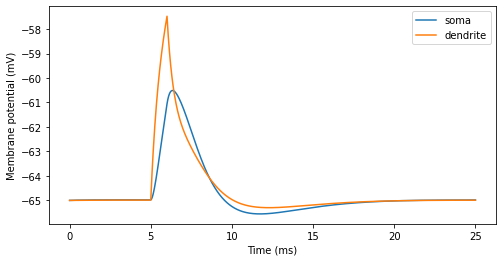

In [13]:
plt.figure(figsize=(8,4))
plt.plot(t_vec, s_vec, label='soma')
plt.plot(t_vec, d_vec, label='dendrite')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.legend()
plt.show()

A spike! It seems the dendritic input caused the membrane potential in the soma to jump. Now we went through the basics of NEURON we can experiment with more interesting cases.

### Exercise 2: Dendritic resolution (50 points)
In reality the biological dendrite does not behave as one compartment. Synaptic input can arrive at different locations along the dendrite. Further, the length and shape of the dendrite has an effect on the current that will eventually reach the soma. To incorporate these effects in our Ball & Stick model we need to increase the number of 𝑆𝑒𝑔𝑚𝑒𝑛𝑡𝑠 in our dendrite 𝑆𝑒𝑐𝑡𝑖𝑜𝑛. Try to set the number of 𝑆𝑒𝑔𝑚𝑒𝑛𝑡𝑠 of the dendrite (𝑛𝑠𝑒𝑔) to 101 (odd value because we evaluate the membrane potential at the middle of the dendrite). What happens to the membrane potential of the dendrite and the soma when applying stimulation at different 𝑆𝑒𝑔𝑚𝑒𝑛𝑡𝑠 along the dendrite? Try experimenting with different dendrite lengths, number of 𝑆𝑒𝑔𝑚𝑒𝑛𝑡𝑠. Can you think of a computation that could be performed by a single dendrite with the potential to be stimulated (e.g. by other neuron's synapses) at different sites along it's shaft?


|-|       soma(0-1)
   `----------------------------------------------------------------------------------------------------|       dend(0-1)



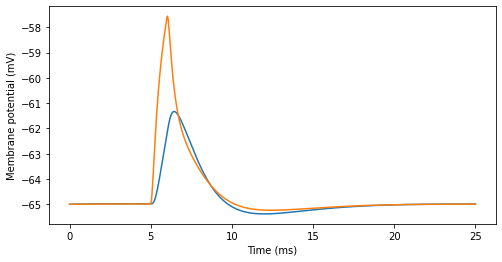

In [14]:
# set the number of Segments (nseg) of the dendrite to 101.
dend.nseg = 101
for seg in dend:
    seg.pas.g = 0.001
    seg.pas.e = -65
    
h.topology()

# apply stimulation at a location along the dendritic shaft
stim = h.IClamp(dend(1))
stim.delay = 5
stim.dur   = 1
stim.amp   = 0.1

# plot the membrane potential in the middle of the dendrite and the soma
t_vec = h.Vector()       # Time vector
t_vec.record(h._ref_t)   # record time

# record from the middle of the soma
s_vec = h.Vector()             # Membrane potential
s_vec.record(soma(0.5)._ref_v) # record from the middle of the soma

# record from the middle of the dendrite
d_vec = h.Vector()             # Membrane potential
d_vec.record(dend(0.5)._ref_v) # record from the middle of the soma

h.tstop = 25.0  # simulation time
h.run()

# plot the trajectories
plt.figure(figsize=(8,4))
plt.plot(t_vec, s_vec, label='soma')
plt.plot(t_vec, d_vec, label='dendrite')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.show()

*The advantage of having detailed dendrites is that you can do non-linear integrations of inputs. For example you can integrate temporal sequences of input. Imagine the difference between a sequence of inputs arriving on the dendrite in the direction of the soma or in the opposite direction. The dendrite will likely be able to make a distinction between the two input sequences.*

### Exercise 3: Cell-class & Ring-network (50 Points)
To make your code more efficient it is often convenient to build classes for objects. An example would be a cell class containing all properties of the cell (i.e. topology, geometry, biophysics). This cell class could be called each time you want to create a cell without the need to set all parameters. Below a template of such a cell class is provided but not all functionality is complete. The goal of this exercise is to complete this class and use it to make a ring-network of Ball-and-Stick neurons. For this model we assume nothing interesting happens in the axon so we don't have to model them explicitely and we can 'connect' the spikes detected at the *soma* of one cell directly to the *dendrite* of the next cell on the ring with some *weight*. 

In the ring-network connect each cell to the next cell on the ring from the middle of the soma of the previous cell to the middle of the dendrite of the next cell. Event-based communication between objects in NEURON takes place via network connection objects called *NetCon*s. Each *NetCon* has a source and target, where the source is the membrane potential of the presynaptic soma and the target the synapse on the postsynaptic dendrite. When the membrane voltage at the *soma* spikes, the *NetCon* sends a message to a target. A synapse is created using the function *h.ExpSyn()* with as only argument the target location (i.e. the middle of the postsynaptic dendrite).
Give each connection on the ring a weight of $0.05 mV$ and a delay of $5 ms$.

We will also use *NetCon* to connect a stimulus to the first cell in the ring-network. The stimulation object is created using *h.NetStim*. This device ejects a number of spikes. Set the *number* argument to 1 and the *delay* to 1. Connect it to the first cell using *NetCon*.

Now simulate the network for $100 ms$ and visualize the membrane voltage of all cells in the network! Now you know how to organize your code in classes and create networks of cells in NEURON!

In [15]:
class Cell:
    def __init__(self, idx):
        self.idx = idx  # index of the cell on the ring
        self.create_sections()
        self.build_topology()
        self.define_geometry()
        self.define_biophysics()
    
    def create_sections(self):
        """Create the sections of the cell."""
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        
    def build_topology(self):
        """Connect the sections of the cell to build a tree."""
        self.dend.connect(self.soma(1)) 

    def define_geometry(self):
        """Set the geometry of the cell."""
        self.soma.L = self.soma.diam = 12.6157 # microns
        self.dend.L = 200  # microns
        self.dend.diam = 1 # microns
        self.dend.nseg = 101
        
    def define_biophysics(self):
        """Set the biophysics of the sections."""   
        for sec in h.allsec():
            sec.Ra = 100   # Axial resistance in Ohm*cm
            sec.cm = 1     # Membrane capacitance in mF/cm^2
        
        self.soma.insert('hh') # insert active Hodgin-Huxley current
        # set the parameters of the active membrane
        for seg in self.soma:
            seg.hh.gnabar = 0.12   # Sodium conductance in S/cm^2
            seg.hh.gkbar  = 0.036  # Potassium conductance in S/cm^2
            seg.hh.gl     = 0.0003 # Leak conductance in S/cm^2
            seg.hh.el     = -54.3  # Reversal potential in mV
            
        # insert a passive membrane ('pas')
        self.dend.insert('pas')
        # set the parameters of the passive membrane
        for seg in self.dend:
            seg.pas.g = 0.001
            seg.pas.e = -65
            

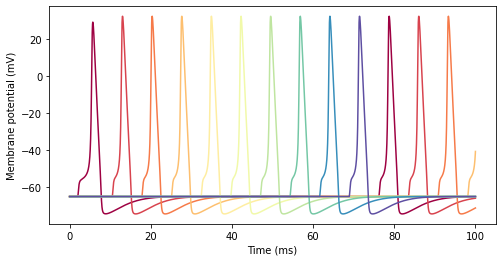

In [16]:
# create the cells
cells = []        # list of cells
N = 10            # number of cells
for i in range(N):
    cell = Cell(i)
    cells.append(cell)
    
# connect the cells
syns = []         # list of synapses
netcons = []      # list of NetCons
for i in range(N):
    src = cells[i]
    tgt = cells[(i + 1) % N]
    
    syn = h.ExpSyn(tgt.dend(0.5))
    nc = h.NetCon(src.soma(0.5)._ref_v, syn, sec=src.soma)
    nc.weight[0] = 0.05
    nc.delay = 5
    netcons.append(nc)
    syns.append(syn)

# stimulate the first cell
stim = h.NetStim()                   # stimulation device generating spike input
syn_ = h.ExpSyn(cells[0].dend(0.5))  # synapse 
stim.number = 1
stim.start = 1
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 1
ncstim.weight[0] = 0.04 # NetCon weight is a vector.

# plot the membrane potential in the middle of the dendrite and the soma
t_vec = h.Vector()       # Time vector
t_vec.record(h._ref_t)   # record time

s_vecs = []
for i in range(N):
    # record from the middle of the soma
    s_vec = h.Vector()                      # Membrane potential
    s_vec.record(cells[i].soma(0.5)._ref_v) # record from the middle of the soma
    s_vecs.append(s_vec)

h.tstop = 100.0  # simulation time
h.run()

# plot the trajectories
plt.figure(figsize=(8,4))
colors = plt.cm.Spectral(np.linspace(0, 1, N))
for i in range(N):
    plt.plot(t_vec, s_vecs[i], color=colors[i])
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.show()